# CHECK LOCAL HIGH & LOW
note: the top or bottom is not at the index[i], i is marking the place where a local top is found, which is at [i-order]

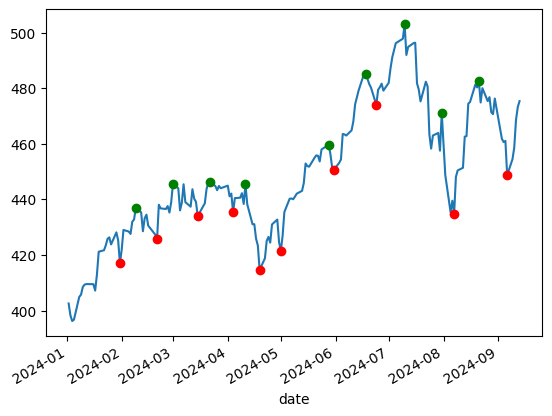

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Checks if there is a local top detected at curr index
def rw_top(data: np.array, curr_index: int, order: int) -> bool:
    if curr_index < order * 2 + 1: # check if there are enough point in either side
        return False

    top = True
    k = curr_index - order
    v = data[k]
    for i in range(1, order + 1):
        if data[k + i] > v or data[k - i] > v: #check the right x range and left x range if any value is larger than data v
            top = False
            break    
    return top

# Checks if there is a local top detected at curr index
def rw_bottom(data: np.array, curr_index: int, order: int) -> bool:
    if curr_index < order * 2 + 1:
        return False

    bottom = True
    k = curr_index - order
    v = data[k]
    for i in range(1, order + 1):
        if data[k + i] < v or data[k - i] < v: #check the right x range and left x range if any value is smaller than data v
            bottom = False
            break  
    return bottom

def rw_extremes(data: np.array, order:int):
    # Rolling window local tops and bottoms
    tops = []
    bottoms = []
    for i in range(len(data)):
        if rw_top(data, i, order):
            # top[0] = confirmation index
            # top[1] = index of top
            # top[2] = price of top
            top = [i, i - order, data[i - order]]
            tops.append(top)
        
        if rw_bottom(data, i, order):
            # bottom[0] = confirmation index
            # bottom[1] = index of bottom
            # bottom[2] = price of bottom
            bottom = [i, i - order, data[i - order]]
            bottoms.append(bottom)
    
    return tops, bottoms

if __name__ == "__main__":
    data = pd.read_csv('C:/Users/chenl/market data export/QQQ.csv')
    data=data.rename(columns={"Unnamed: 0":"date"})
    data['date'] = data['date'].astype('datetime64[s]')
    data = data.set_index('date')

    tops, bottoms = rw_extremes(data['Close'].to_numpy(), 5)
    data['Close'].plot()
    idx = data.index
    for top in tops:
        plt.plot(idx[top[1]], top[2], marker='o', color='green')

    for bottom in bottoms:
        plt.plot(idx[bottom[1]], bottom[2], marker='o', color='red')

    plt.show()


# directional change - turning points for reverse trade
note: with price action that confirm a bottom or top following by a retraces of price by x %


the variations can be replaced by ATR or other variation indicators. 

the high and low can be replace by just close, no neccesory to specify with high and low


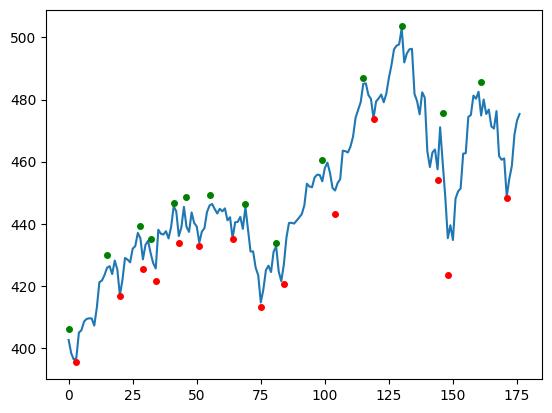

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf

def directional_change(Close: np.array, High: np.array, Low: np.array, sigma: float):
    up_zig = True # This flag indicates whether the last extreme was a bottom. It starts as True as the first detected extreme will be a top after the initial low.
    tmp_max = High[0]
    tmp_min = Low[0]
    tmp_max_i = 0
    tmp_min_i = 0

    tops = []
    bottoms = []

    for i in range(len(Close)):
        if up_zig: # Last extreme is a bottom
            if High[i] > tmp_max:
                # New high, update 
                tmp_max = High[i]
                tmp_max_i = i
            elif Close[i] < tmp_max - tmp_max * sigma: # no new high detected, check for retracement 
                # Price retraced by sigma %. Top confirmed, record it
                # top[0] = confirmation index
                # top[1] = index of top
                # top[2] = price of top
                top = [i, tmp_max_i, tmp_max] # label the last new high price and index-position
                tops.append(top)

                # Setup for next bottom
                up_zig = False
                tmp_min = Low[i] # current new low
                tmp_min_i = i
        else: # Last extreme is a top
            if Low[i] < tmp_min:
                # New low, update 
                tmp_min = Low[i]
                tmp_min_i = i
            elif Close[i] > tmp_min + tmp_min * sigma: 
                # Price retraced by sigma %. Bottom confirmed, record it
                # bottom[0] = confirmation index
                # bottom[1] = index of bottom
                # bottom[2] = price of bottom
                bottom = [i, tmp_min_i, tmp_min]
                bottoms.append(bottom)

                # Setup for next top, turn to look for highs
                up_zig = True
                tmp_max = High[i]
                tmp_max_i = i

    return tops, bottoms

def get_extremes(ohlc: pd.DataFrame, sigma: float): # function didn't call, pending useage
    tops, bottoms = directional_change(ohlc['Close'], ohlc['High'], ohlc['Low'], sigma)
    tops = pd.DataFrame(tops, columns=['conf_i', 'ext_i', 'ext_p']) #confirmation index,index of top,price of top
    bottoms = pd.DataFrame(bottoms, columns=['conf_i', 'ext_i', 'ext_p'])
    tops['type'] = 1 #add new column to distinguish top and bottom
    bottoms['type'] = -1
    extremes = pd.concat([tops, bottoms])
    extremes = extremes.set_index('conf_i')
    extremes = extremes.sort_index()
    return extremes

if __name__ == '__main__':
    data = pd.read_csv('C:/Users/chenl/market data export/QQQ.csv')
    data=data.rename(columns={"Unnamed: 0":"date"})
    data['date'] = data['date'].astype('datetime64[s]')
    data = data.set_index('date')
    tops, bottoms = directional_change(data['Close'].to_numpy(), data['High'].to_numpy(), data['Low'].to_numpy(), 0.02)

    pd.Series(data['Close'].to_numpy()).plot()
    idx = data.index
    for top in tops:
        plt.plot(top[1], top[2], marker='o', color='green', markersize=4)
    for bottom in bottoms:
        plt.plot(bottom[1], bottom[2], marker='o', color='red', markersize=4)
    

    plt.show()

# perceptually_important
finding important points (local highs & lows and draw line), can be used to further stimulation pattern and prediction. Finding max distant point from 2 adjacent PIPs in the segment. 


note:




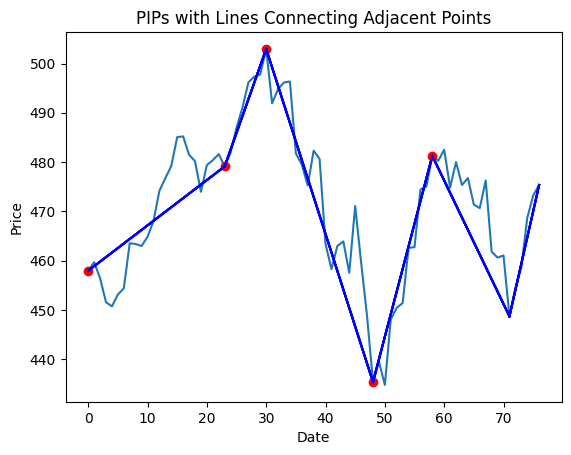

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
def find_pips(data: np.array, n_pips: int, dist_measure: int): #choose n important points targetsl dist type choice 1 2 3
    # dist_measure
    # 1 = Euclidean Distance
    # 2 = Perpindicular Distance
    # 3 = Vertical Distance

    #start with 2 points, begin and end price
    pips_x = [0, len(data) - 1]  # Index
    pips_y = [data[0], data[-1]] # Price

    for curr_point in range(2, n_pips): # begin and end points were chosen already
        md = 0.0 # Max distance
        md_i = -1 # Max distance index
        insert_index = -1
        for k in range(0, curr_point - 1):

            # Left adjacent, right adjacent indices of PIPs
            left_adj = k
            right_adj = k + 1

            time_diff = pips_x[right_adj] - pips_x[left_adj]
            price_diff = pips_y[right_adj] - pips_y[left_adj]
            slope = price_diff / time_diff
            intercept = pips_y[left_adj] - pips_x[left_adj] * slope;

            for i in range(pips_x[left_adj] + 1, pips_x[right_adj]):
                
                d = 0.0 # Distance
                if dist_measure == 1: # Euclidean distance
                    d =  ( (pips_x[left_adj] - i) ** 2 + (pips_y[left_adj] - data[i]) ** 2 ) ** 0.5
                    d += ( (pips_x[right_adj] - i) ** 2 + (pips_y[right_adj] - data[i]) ** 2 ) ** 0.5
                elif dist_measure == 2: # Perpindicular distance
                    d = abs( (slope * i + intercept) - data[i] ) / (slope ** 2 + 1) ** 0.5
                else: # Vertical distance    
                    d = abs( (slope * i + intercept) - data[i] )

                if d > md:
                    md = d
                    md_i = i
                    insert_index = right_adj

        pips_x.insert(insert_index, md_i)
        pips_y.insert(insert_index, data[md_i])

    return pips_x, pips_y

def draw_lines_between_pips(pips_x, pips_y):
    """Draw straight lines between adjacent PIPs."""
    for i in range(len(pips_x) - 1):
        # Draw a line between the current PIP and the next PIP
        plt.plot([pips_x[i], pips_x[i+1]], [pips_y[i], pips_y[i+1]], color='blue')

if __name__ == "__main__":
    data = pd.read_csv('C:/Users/chenl/market data export/QQQ.csv')
    data=data.rename(columns={"Unnamed: 0":"date"})
    data['date'] = data['date'].astype('datetime64[s]')
    data = data.set_index('date')

    # setting range of slice to analyze, change this setting for different dataset
    i = 200 # index of starting slicing points
    x = data['Close'].iloc[i-100:i].to_numpy()
    pips_x, pips_y = find_pips(x, 7, 2) #

    #graph and label
    pd.Series(x).plot()
    for i in range(5):
        plt.plot(pips_x[i], pips_y[i], marker='o', color='red')
        draw_lines_between_pips(pips_x, pips_y)

    # Show the plot with lines and PIPs
    plt.title("PIPs with Lines Connecting Adjacent Points")
    plt.xlabel("Date")
    plt.ylabel("Price")
 
    plt.show()

In [3]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import mplfinance as mpf
from pyclustering.cluster.silhouette import silhouette_ksearch_type, silhouette_ksearch
from pyclustering.cluster.kmeans import kmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from perceptually_important import find_pips


class PIPPatternMiner:

    def __init__(self, n_pips: int, lookback: int, hold_period: int):
        self._n_pips = n_pips
        self._lookback = lookback
        self._hold_period = hold_period
        
        self._unique_pip_patterns = []
        self._unique_pip_indices = []
        self._cluster_centers = []
        self._pip_clusters = []

        self._cluster_signals = []
        self._cluster_objs = []

        self._long_signal = None
        self._short_signal = None

        self._selected_long = []
        self._selected_short = []

        self._fit_martin = None
        self._perm_martins = []
        
        self._data = None # Array of log closing prices to mine patterns
        self._returns = None # Array of next log returns, concurrent with _data

    def get_fit_martin(self):
        return self._fit_martin

    def get_permutation_martins(self):
        return self._perm_martins

    def plot_cluster_examples(self, candle_data: pd.DataFrame, cluster_i: int, grid_size: int = 5):
        plt.style.use('dark_background')
        fig, axs = plt.subplots(grid_size, grid_size)
        flat_axs = axs.flatten()
        for i in range(len(flat_axs)):
            if i >= len(self._pip_clusters[cluster_i]):
                break
            
            pat_i = self._unique_pip_indices[self._pip_clusters[cluster_i][i]]
            data_slice = candle_data.iloc[pat_i - self._lookback + 1: pat_i + 1]
            idx = data_slice.index
            plot_pip_x, plot_pip_y = find_pips(data_slice['close'].to_numpy(), self._n_pips, 3)
            
            pip_lines = []
            colors = []
            for line_i in range(self._n_pips - 1):
                l0 = [(idx[plot_pip_x[line_i]], plot_pip_y[line_i]), (idx[plot_pip_x[line_i + 1]], plot_pip_y[line_i + 1])]
                pip_lines.append(l0)
                colors.append('w')

            mpf.plot(data_slice, type='candle',alines=dict(alines=pip_lines, colors=colors), ax=flat_axs[i], style='charles', update_width_config=dict(candle_linewidth=1.75) )
            flat_axs[i].set_yticklabels([])
            flat_axs[i].set_xticklabels([])
            flat_axs[i].set_xticks([])
            flat_axs[i].set_yticks([])
            flat_axs[i].set_ylabel("")

        fig.suptitle(f"Cluster {cluster_i}", fontsize=32)
        plt.show()


    def predict(self, pips_y: list):
        norm_y = (np.array(pips_y) - np.mean(pips_y)) / np.std(pips_y)

        # Find cluster
        best_dist = 1.e30
        best_clust = -1
        for clust_i in range(len(self._cluster_centers)):
            center = np.array(self._cluster_centers[clust_i])
            dist = np.linalg.norm(norm_y-center)
            if dist < best_dist:
                best_dist = dist
                best_clust = clust_i

        if best_clust in self._selected_long:
            return 1.0
        elif best_clust in self._selected_short:
            return -1.0
        else:
            return 0.0
    
    
    def train(self, arr: np.array, n_reps=-1):
        self._data = arr
        self._returns = pd.Series(arr).diff().shift(-1)
        self._find_unique_patterns()
        

        search_instance = silhouette_ksearch(
                self._unique_pip_patterns, 5, 40, algorithm=silhouette_ksearch_type.KMEANS).process()
        
        amount = search_instance.get_amount()
        self._kmeans_cluster_patterns(amount)

        self._get_cluster_signals()
        self._assign_clusters()
        self._fit_martin = self._get_total_performance()
        
        print(self._fit_martin)

        if n_reps <= 1:
            return

        # Start monte carlo permutation test
        data_copy = self._data.copy()
        returns_copy = self._returns.copy()
        
        for rep in range(1, n_reps):
            x = np.diff(data_copy).copy()
            np.random.shuffle(x)
            x = np.concatenate([np.array([data_copy[0]]), x])
            self._data = np.cumsum(x)
            self._returns = pd.Series(self._data).diff().shift(-1)
            print("rep", rep) 
            self._find_unique_patterns()
            search_instance = silhouette_ksearch(
                    self._unique_pip_patterns, 5, 40, algorithm=silhouette_ksearch_type.KMEANS).process()
            amount = search_instance.get_amount()
            self._kmeans_cluster_patterns(amount)
            self._get_cluster_signals()
            self._assign_clusters()
            perm_martin = self._get_total_performance()
            self._perm_martins.append(perm_martin)


    def _find_unique_patterns(self):
        # Find unique pip patterns in data
        self._unique_pip_indices.clear()
        self._unique_pip_patterns.clear()
        
        last_pips_x = [0] * self._n_pips
        for i in range(self._lookback - 1, len(self._data) - self._hold_period):
            start_i = i - self._lookback + 1
            window = self._data[start_i: i + 1]
            pips_x, pips_y = find_pips(window, self._n_pips, 3)
            pips_x = [j + start_i for j in pips_x]

            # Check internal pips to see if it is the same as last
            same = True
            for j in range(1, self._n_pips - 1):
                if pips_x[j] != last_pips_x[j]:
                    same = False
                    break
            
            if not same:
                # Z-Score normalize pattern
                pips_y = list((np.array(pips_y) - np.mean(pips_y)) / np.std(pips_y))
                self._unique_pip_patterns.append(pips_y)
                self._unique_pip_indices.append(i)

            last_pips_x = pips_x


    def _kmeans_cluster_patterns(self, amount_clusters):
        # Cluster Patterns
        initial_centers = kmeans_plusplus_initializer(self._unique_pip_patterns, amount_clusters).initialize()
        kmeans_instance = kmeans(self._unique_pip_patterns, initial_centers)
        kmeans_instance.process()

        # Extract clustering results: clusters and their centers
        self._pip_clusters = kmeans_instance.get_clusters()
        self._cluster_centers = kmeans_instance.get_centers()

    def _get_martin(self, rets: np.array):
        rsum = np.sum(rets)
        short = False
        if rsum < 0.0:
            rets *= -1
            rsum *= -1
            short = True

        csum = np.cumsum(rets)
        eq = pd.Series(np.exp(csum))
        sumsq = np.sum( ((eq / eq.cummax()) - 1) ** 2.0 )
        ulcer_index = (sumsq / len(rets)) ** 0.5
        martin = rsum / ulcer_index
        if short:
            martin = -martin

        return martin

    def _get_cluster_signals(self):
        self._cluster_signals.clear()

        for clust in self._pip_clusters: # Loop through each cluster
            signal = np.zeros(len(self._data))
            for mem in clust: # Loop through each member in cluster
                arr_i = self._unique_pip_indices[mem]
                
                # Fill signal with 1s following pattern identification
                # for hold period specified
                signal[arr_i: arr_i + self._hold_period] = 1. 
            
            self._cluster_signals.append(signal)

    def _assign_clusters(self):
        self._selected_long.clear()
        self._selected_short.clear()
        
        # Assign clusters to long/short/neutral
        cluster_martins = []
        for clust_i in range(len(self._pip_clusters)): # Loop through each cluster
            sig = self._cluster_signals[clust_i]
            sig_ret = self._returns * sig
            martin = self._get_martin(sig_ret)
            cluster_martins.append(martin)

        best_long = np.argmax(cluster_martins)
        best_short = np.argmin(cluster_martins)
        self._selected_long.append(best_long)
        self._selected_short.append(best_short)

    def _get_total_performance(self):

        long_signal = np.zeros(len(self._data))
        short_signal = np.zeros(len(self._data))

        for clust_i in range(len(self._pip_clusters)):
            if clust_i in self._selected_long:
                long_signal += self._cluster_signals[clust_i]
            elif clust_i in self._selected_short:
                short_signal += self._cluster_signals[clust_i]
        
        long_signal /= len(self._selected_long)
        short_signal /= len(self._selected_short)
        short_signal *= -1

        self._long_signal = long_signal
        self._short_signal = short_signal
        rets = (long_signal + short_signal) * self._returns

        martin = self._get_martin(rets)
        return martin

if __name__ == '__main__':
    data = pd.read_csv('C:/Users/chenl/market data export/QQQ.csv')
    data=data.rename(columns={"Unnamed: 0":"date"})
    data['date'] = data['date'].astype('datetime64[s]')
    data = data.set_index('date')
    data = np.log(data)

    plt.style.use('dark_background')

    data = data[data.index < '01-01-2025']
    arr = data['close'].to_numpy()
    pip_miner = PIPPatternMiner(n_pips=5, lookback=24, hold_period=6)
    pip_miner.train(arr, n_reps=-1)

ModuleNotFoundError: No module named 'pyclustering'